# Damage transport: zero stress

This notebook modifies icepack's Damage Transport module to use the zero-stress crevasse depth criterion. That is, we assume crevasses to penetrate to the depth at which the principal tension (which opens crevasses) is balanced by the overburden pressure (which closes them). Damage, which is calculated as the ratio of crevasse depth to the full ice thickness, then modifies the ice rheology as previously implemented [in this icepack tutorial](https://icepack.github.io/notebooks/tutorials/02-synthetic-ice-shelf/).

The application presented in this notebook is similar to Figure 3 in [Miele et al., 2023](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2022JF006959). That is, we consider a rectangular ice shelf whose sidewalls provide friction over only a limited subset of the domain. As it exits the zone of maximal sidewall resistance, the shelf attains a high extensional strain rate, which causes fracture.

## Imports

In [1]:
%%capture
path = '/home/sermilik/firedrake_stuff/figures/flow_flexure' #modify to preferred destination for saving figs

from firedrake import *
import icepack
from icepack.calculus import sym_grad
import matplotlib.pyplot as plt
import numpy as np
from operator import itemgetter
import os
import tqdm #displays progress bars in long-running loops

!pip install import_ipynb #this block is to allow importing transport_solver, which is not yet a part of icepack
import import_ipynb
os.chdir('/home/sermilik/firedrake_stuff/flow') #location of the transport solver
import transport_solver

## Mesh, function spaces, trial and test functions

The shelf will be rectangular, with length ```Lx``` and width ```Ly```.

In [2]:
nx, ny = 60, 30 #number of elements in x, y
Lx, Ly = 6000, 3000 #length, width in meters
mesh = RectangleMesh(nx, ny, Lx, Ly)
x, y = SpatialCoordinate(mesh)

Q = FunctionSpace(mesh, 'CG', 2) #for interpolating scalars
V = VectorFunctionSpace(mesh, 'CG', 2)  #vectors
S = TensorFunctionSpace(mesh, 'DG', 1) #and tensors

u = Function(V) #velocity
v = TestFunction(V)

## Physical constants, shelf geometry

In [3]:
from icepack.constants import year #number of seconds in a year
ρ_i = 917 #ice density in kg/m^3
g = 9.81 #gravity in N/kg
T = Constant(273.15) #temperature (K). 273.15 is freezing
A = icepack.rate_factor(T) #A from Glen's law

H_gl = 500 #thickness at upstream boundary (m)
thick_grad = -0.0 #thickness gradient 
H0 = project(H_gl + thick_grad*x, Q) #initial thickness projected onto CG elements

## Modify some icepack modules to incorporate damage

Damage softening is accounted for by the function ```viscosity_damaged```, which modifies the default ```viscosity_depth_averaged``` functional by updating the fluidity paremeter $A$ (see [this icepack tutorial](https://icepack.github.io/notebooks/tutorials/02-synthetic-ice-shelf/)). We'll also write a function, ```effective_viscosity```, that returns the effective viscosity of the damaged ice (we'll need this to calculate membrane stresses, and, therefore, fracture density). 

Finally, the function ```damage``` will calculate and advect the damage field corresponding to Nye zero-stress crevasse depths. The damage from the previous step is advected forward using ```TransportSolver```, and it is compared with the present step's Nye crevasse depths. Where damage has increased, the value is updated; elsewhere, the advected values from the previous step are retained (i.e., there is no healing). 

In [4]:
def viscosity_damaged(**kwargs):
    n = 3 #glen's law exponent
    u, h, A, D = itemgetter('velocity', 'thickness', 'fluidity', 'damage')(kwargs)
    A_damaged = (1 - D)**(-n)*A
    return icepack.models.viscosity.viscosity_depth_averaged(velocity = u, thickness = h, 
                                                             fluidity = A_damaged)
    
def effective_viscosity(**kwargs): #also define a function that returns the effective viscosity
    n = 3
    u, D = itemgetter('velocity', 'damage')(kwargs)
    ε = sym(grad(u))
    ε_min = Constant(kwargs.get('strain_rate_min', icepack.constants.strain_rate_min))
    ε_e = icepack.models.viscosity._effective_strain_rate(ε, ε_min) 
    A_damaged = (1 - D)**(-n)
    ν = 1/2*A_damaged**(-1/n)*ε_e**(1/n - 1) #effective viscosity in MPa*yrs
    return ν #return ν in units of MPa*yrs

def damage(Δt, **kwargs): 
    u, H, D_old, inflow, accumulation = itemgetter('velocity', 'thickness', 'damage', 
                                                          'damage_inflow', 'damage_accumulation')(kwargs)
    Q = D_old.function_space()

    model = transport_solver.TransportEquation(field_name = 'damage', conservative = False)
    solver = transport_solver.TransportSolver(model)
    D_old = solver.prognostic_solve(Δt, velocity = u, damage = D_old, #first, advect the existing damage field
                     damage_inflow = inflow, damage_accumulation = accumulation)

    ν = effective_viscosity(velocity = u, damage = D_old) #in MPa*yrs
    ε = sym(grad(u)) #strain rate tensor, /yr
    τ = 2*ν*ε #depth-averaged deviatoric stress tensor in MPa
    τ_1 = icepack.utilities.eigenvalues(τ)[0] #depth-averaged 1st principal tension

    D_new = (τ_1 + tr(τ))*1e6/(ρ_i*g)/H #theoretical crevasse depth, by the zero stress criterion (normalized by thickness)
    D_new = min_value(D_new, 1) #halt crevasse growth at one ice thickness
    D = max_value(D_new, D_old) #update the crevasse depth only if it is deeper than existing crevasses (i.e., no healing)
    D = Function(Q).project(D)

    return D

## Set up the solver

The key to the setup here is to impose a spatially variable coefficient of sidewall friction. The coefficient of sidewall friction will be zero at the upstream and downstream boundaries of the domain, but it will briefly rise to some baseline value at the center of the domain (see output figure below).

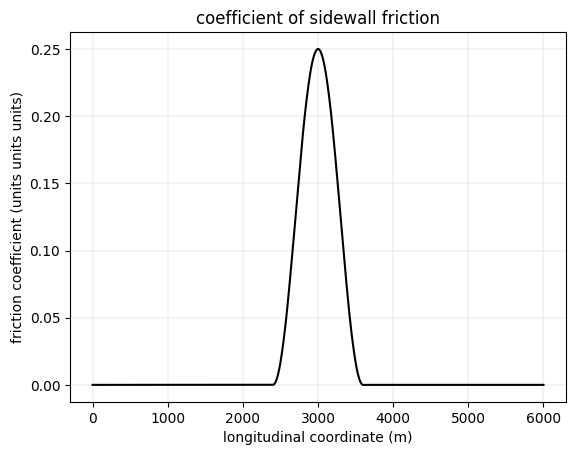

In [5]:
################################
################################
### parameters for iteration ###
################################
################################

Δt = 1/4 #length of timestep in years
num_timesteps = int(10/Δt) #spin up for 10 years

##########################
##########################
### set up flow solver ###
##########################
##########################

ux_gl = 100 #upstream boundary boundary condition in meters per year
u0 = project(as_vector([ux_gl, 1e-50]), V) #initial velocity (u_x, u_y) for imposing Dirichlet BCs

C0 = 0.25 #maximum coefficient of sidewall friction
px, r = Lx/2, Lx/10 #x-coordinate of max friction, length of ramp-up
C = Function(Q).project(
    conditional(abs(x - px) <= r, 1/2*C0*cos(pi*(x - px)/r) + 1/2*C0, 0)) #(see output figure below)

opts = {
    'dirichlet_ids': [1], #boundaries are labeled (1, 2, 3, 4) = (upstream, downstream, left, right)
    'side_wall_ids': [3, 4],
    'ice_front_ids': [2],
    #'diagnostic_solver_type': 'petsc',
    'diagnostic_solver_parameters': {
        'ksp_type': 'cg',
        'pc_type': 'mg',
        'pc_mg_cycle_type': 'w',
        'snes_line_search_type': 'cp',
    },
    'prognostic_solver_parameters': {
        'ksp_type': 'gmres',
        'pc_type': 'ilu',
    },
}

flow_model = icepack.models.IceShelf(viscosity = viscosity_damaged)
flow_solver = icepack.solvers.FlowSolver(flow_model, **opts)

############################
############################
### initial damage field ###
############################
############################

D0 = Function(Q).project(Constant(0)) #initial damage field

####################################
####################################
### display friction coefficient ###
####################################
####################################

os.chdir(path) #for saving figures
X = np.array([(k, Ly/2) for k in range (Lx+1)]) #along-flow line for getting geometry profiles
C_profile = np.array(C.at(X, tolerance = 1e-10))

plt.figure()
plt.title('coefficient of sidewall friction')
plt.plot(C_profile, color='k', label = 'friction')
plt.xlabel('longitudinal coordinate (m)')
plt.ylabel('friction coefficient (units units units)')
plt.grid(linewidth=0.2)

## Iteratively solve

We'll simultaneously solve two problems: one in which the shelf's rheology is altered by damage, and one in which it is not. The highest fracture density occurs at the sidewalls beyond the location of maximal friction, softening the downstream margins. Consequently, the downstream part of the damaged shelf will flow slightly faster than the undamaged version.

100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [00:53<00:00,  1.34s/it]


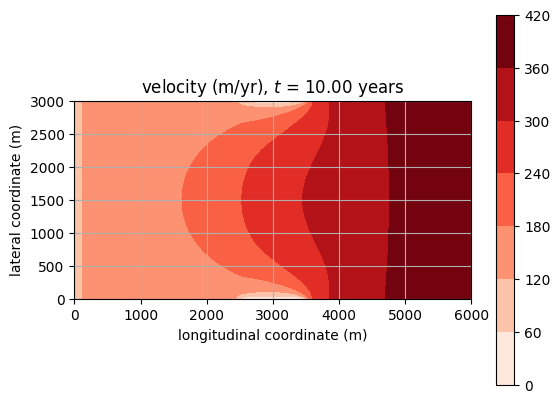

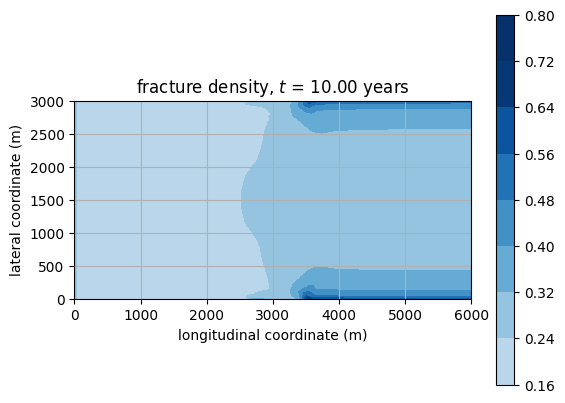

In [6]:
u, H = u0.copy(deepcopy=True), H0.copy(deepcopy=True)
D = D0.copy(deepcopy=True)

for step in tqdm.trange(num_timesteps):
    
    #############################
    #############################
    ### get velocity solution ###
    #############################
    #############################
    
    u = flow_solver.diagnostic_solve(velocity = u, side_friction = C, 
                                thickness = H, fluidity = A, damage = D) #damage influences this velocity solution
 
    ##################################
    ##################################
    ### dynamically thin the shelf ###
    ##################################
    ##################################

    H = flow_solver.prognostic_solve(Δt, thickness = H, velocity = u, 
                           thickness_inflow = H0, accumulation = Constant(0))

    ###########################
    ###########################
    ### update damage field ###
    ###########################
    ###########################

    D = damage(Δt, velocity = u, thickness = H, damage = D, damage_inflow = Constant(0), damage_accumulation = Constant(0))

    #################
    #################
    ### save figs ###
    #################
    #################
    
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    vel_plot = tricontourf(u, axes = ax, cmap = 'Reds', vmin = 0, vmax = 400) #damaged velocity plot
    plt.colorbar(vel_plot)
    plt.title('velocity (m/yr), $t$ = {:.2f} years'.format(step*Δt + Δt))
    plt.xlabel('longitudinal coordinate (m)')
    plt.ylabel('lateral coordinate (m)')
    plt.grid()
    plt.savefig('vel_iteration_{}'.format(step + 1))
    if step < num_timesteps - 1:
        plt.close()

    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    frac_plot = tricontourf(D, axes = ax, cmap = 'Blues', vmin = 0, vmax = 0.7) #damage plot
    plt.colorbar(frac_plot)
    plt.title('fracture density, $t$ = {:.2f} years'.format(step*Δt + Δt))
    plt.xlabel('longitudinal coordinate (m)')
    plt.ylabel('lateral coordinate (m)')
    plt.grid()
    plt.savefig('fracture_iteration_{}'.format(step + 1))
    if step < num_timesteps - 1:
        plt.close()